##### Master Degree in Computer Science and Data Science for Economics

# Word2Vec
## A toy example and from scratch implementation

### Alfio Ferrara

For the details about the model, see [wordvec.py](./nlp/wordvec.py)

## A simple toy dataset
Let's take a simple example with pseudo docs representing different weather conditions

In [2]:
import json

In [3]:
with open('../data/weather.json', 'r') as file_in:
    data = json.load(file_in)
weather = data['weather']
for doc in weather:
    print(" | ".join(doc))

mountains | snow | ice | peak | woods | cold
beach | sand | sea | wave | sun | hot
desert | dune | cactus | sand | sun | arid
forest | tree | leaf | animal | rain | humidity
river | water | fish | spring | current | bank
sky | cloud | wind | rain | thunder | rainbow


## Create SkipGram dataloader

In [4]:
import nlp.wordbags as wb
import pandas as pd
import torch 

In [5]:
bow = wb.Bow(corpus=weather)
data_loader, inputs, outputs = bow.one_hot_skip_gram_dataloader(window=2, batch=2)

In [6]:
readable_input = pd.DataFrame(inputs, columns=bow.vocabulary)
readable_input.iloc[0].head()

mountains    1.0
snow         0.0
ice          0.0
peak         0.0
woods        0.0
Name: 0, dtype: float32

In [7]:
readable_target = pd.DataFrame(outputs, columns=bow.vocabulary)
readable_target.iloc[0].head()

mountains    0.0
snow         1.0
ice          1.0
peak         0.0
woods        0.0
Name: 0, dtype: float32

In [8]:
for x, y in data_loader:
    print(f"Input: {x}")
    print(f"Target: {y}")
    break 

Input: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Target: tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [9]:
for i, (x, y) in enumerate(data_loader):
    for batch_i in range(x.shape[0]):
        x_indices = torch.where(x[batch_i] == 1)[0].numpy()
        y_indices = torch.where(y[batch_i] == 1)[0].numpy()
        input_word = f"{[bow.idx2word[w_x] for w_x in x_indices]}"
        target_word = f"{[bow.idx2word[w_y] for w_y in y_indices]}"
        print(f"{input_word} ==> {target_word}")
    if i > 5:
        break 

['mountains'] ==> ['snow', 'ice']
['snow'] ==> ['mountains', 'ice', 'peak']
['ice'] ==> ['mountains', 'snow', 'peak', 'woods']
['peak'] ==> ['snow', 'ice', 'woods', 'cold']
['woods'] ==> ['ice', 'peak', 'cold']
['cold'] ==> ['peak', 'woods']
['beach'] ==> ['sand', 'sea']
['sand'] ==> ['beach', 'sea', 'wave']
['sea'] ==> ['beach', 'sand', 'wave', 'sun']
['wave'] ==> ['sand', 'sea', 'sun', 'hot']
['sun'] ==> ['sea', 'wave', 'hot']
['hot'] ==> ['wave', 'sun']
['desert'] ==> ['dune', 'cactus']
['dune'] ==> ['sand', 'desert', 'cactus']


## Build and train a predictor

In [10]:
from nlp.wordvec import Word2WordPrediction, Word2VecModel
from nlp.w2w_readers import WordEmbeddings

In [11]:
w2w = Word2WordPrediction(input_dim=bow.size, hidden_dim=4)
epochs = 50
learning_rate = 0.01
history = w2w.train(data_loader=data_loader, epochs=epochs, 
                    learning_rate=learning_rate)
print(history[0], history[-1])

100%|██████████| 50/50 [00:00<00:00, 348.00it/s]

10.489991717868381 9.715192317962646


### Predict next word

In [12]:
model = WordEmbeddings(words=bow, model=w2w)

In [13]:
query = 'desert'
next_word = model.predict(query, topk=10)
next_word

cactus    0.983893
sand      0.007746
leaf      0.004653
woods     0.002746
snow      0.000616
sea       0.000071
spring    0.000063
tree      0.000047
river     0.000026
dune      0.000026
dtype: float32

### Generate text

In [14]:
import numpy as np 

In [15]:
start = "desert"
text = [start]
for i in range(6):
    p = model.predict(start)
    next_word = np.random.choice(p.index.values, p=p.values / p.values.sum())
    text.append(next_word)
    start = next_word

print(" ".join(text))

desert cactus sun cactus sand sun cactus


## Word Embeddings

In [16]:
search = 'dune'

In [17]:
model[search]

array([ 1.2090666,  1.2371256, -1.4616163, -1.3776888], dtype=float32)

### Most similar

In [18]:
model.most_similar(search, topk=10)

dune      1.000000
sun       0.986408
desert    0.872596
beach     0.849499
forest    0.502287
wave      0.491123
tree      0.488658
sea       0.471971
arid      0.470290
cactus    0.451583
Name: dune, dtype: float32

### Visual map

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-dark-palette')

In [20]:
tsne = TSNE(n_components=2)
vectors = model.vectors(bow.vocabulary)
v2d = tsne.fit_transform(vectors)

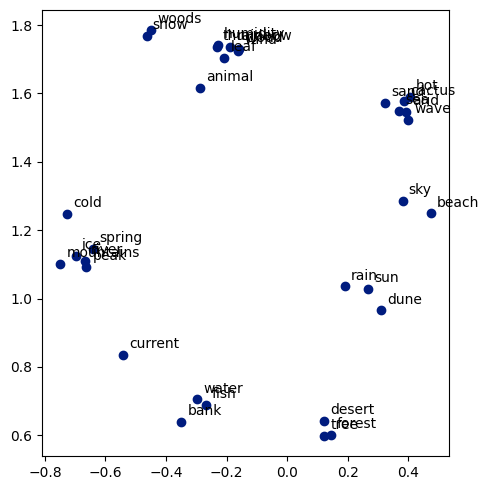

In [21]:
selected_words = bow.vocabulary
indexes = [bow.word2idx[w] for w in selected_words]
selected2d = v2d[indexes]

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(selected2d[:,0], selected2d[:, 1])
for i, w in enumerate(selected_words):
    ax.text(selected2d[i][0] + .02, selected2d[i][1] + .02, w)
plt.tight_layout()
plt.show()

### Directions

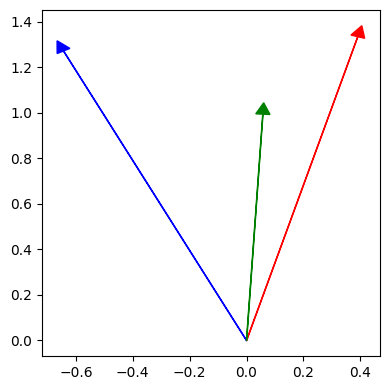

In [22]:
def pointer(group, vectors):
    g = vectors[[bow.word2idx[w] for w in group]]
    return g.mean(axis=0)

group1 = ['dune', 'beach', 'cactus', 'arid']
group2 = ['snow', 'peak', 'mountains', 'ice']
group3 = ['forest', 'tree', 'rain', 'humidity']
g1 = pointer(group1, v2d)
g2 = pointer(group2, v2d)
g3 = pointer(group3, v2d)

fig, ax = plt.subplots(figsize=(4, 4))
ax.arrow(0, 0, g1[0], g1[1], head_width=0.05, head_length=0.05, fc='red', ec='red')
ax.arrow(0, 0, g2[0], g2[1], head_width=0.05, head_length=0.05, fc='blue', ec='blue')
ax.arrow(0, 0, g3[0], g3[1], head_width=0.05, head_length=0.05, fc='green', ec='green')
plt.tight_layout()
plt.show()

## Compositionality

In [23]:
answer, a_vector = model.analogy('sea', 'wave', 'desert')
print(answer)

desert


In [24]:
model.common_meanings(['sea', 'wave', 'desert', 'sand'])

wave      0.914150
beach     0.905733
sea       0.893922
arid      0.881191
cactus    0.876507
sun       0.777162
dune      0.712349
hot       0.707097
sand      0.679534
desert    0.443886
dtype: float32

In [25]:
model.spot_odd_one(words=['mountains', 'peak', 'snow', 'sand'])

sand         0.269533
peak         0.643646
snow         0.818660
mountains    0.904269
dtype: float32

In [32]:
model.search(positive=['sea'], negative=['wave'])

cold        0.651316
ice         0.607832
snow        0.559899
woods       0.558223
peak        0.528262
humidity    0.509921
river       0.502198
spring      0.494384
animal      0.485455
thunder     0.469369
dtype: float32

In [33]:
model.search(positive=['sea', 'desert'], negative=['wave'])

desert       0.998238
sun          0.867434
dune         0.867257
peak         0.567095
forest       0.536191
tree         0.522827
ice          0.500448
cold         0.498755
beach        0.490832
mountains    0.270256
dtype: float32